# Recurrent Neural Networks (RNNs) with TensorFlow

| Model                 | Test MSE | N Epoch | Training Time | Dataset Shape |
|-----------------------|----------|---------|---------------|---------------|
| Baseline (Last Value) | 0.02     | -       | <1s           | 7000x50x1     |
| Simple Dense          | 0.0055   | 10      | 8s            | 7000x50x1     |
| Simple RNN            | 0.0028   | 10      | 46s           | 7000x50x1     |
| Deep RNN              | 0.0025   | 10      | 1min 20s      | 7000x50x1     |
| Long SEQ RNN          | 0.0065   | 10      | 1min 39s      | 7000x50x1     |
| LSTM                  | 0.0026   | 10      | 1min 33s      | 7000x50x1     |
| GRU                   | 0.0115   | 10      | 1min 46s      | 7000x50x1     |
| Conv1D + RNN          | N/A      | 10      | N/A           | 7000x50x1     |
| WaveNet               | 0.01154  | 10      | 41s           | 7000x50x1     |

## Import Libraries

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, losses, models
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl

In [19]:
sns.set_style('whitegrid')

In [20]:
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=y_true.flatten(),
        y=y_pred.flatten(),
        alpha=0.5
    )
    sns.lineplot(
        x=y_true.flatten(),
        y=y_true.flatten(),
        color='red'
    )

    # plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(False)
    plt.show()

In [22]:
def plot_learning_curves(loss, val_loss):
        # Prepare data for seaborn
        epochs = np.arange(1, len(loss) + 1)
        data = {
            "Epoch": np.concatenate([epochs, epochs]),
            "Loss": np.concatenate([loss, val_loss]),
            "Type": ["Training"] * len(loss) + ["Validation"] * len(val_loss),
        }

        plt.figure(figsize=(8, 5))
        sns.lineplot(
            x="Epoch",
            y="Loss",
            hue="Type",
            style="Type",
            markers=True,
            dashes=False,
            data=data,
        )

        plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        plt.axis((1, 20, 0, 0.05))
        plt.legend(fontsize=14)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(False)
        plt.tight_layout()

### Create a timeseries dataset

In [5]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # add noise
    return series[..., np.newaxis].astype(np.float32)

In [6]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### Base Prediction Method

In [7]:
y_pred = X_valid[:, -1]
baseline_mse = np.mean(losses.mse(y_valid, y_pred))
print("Baseline MSE:", baseline_mse)

Baseline MSE: 0.020863106


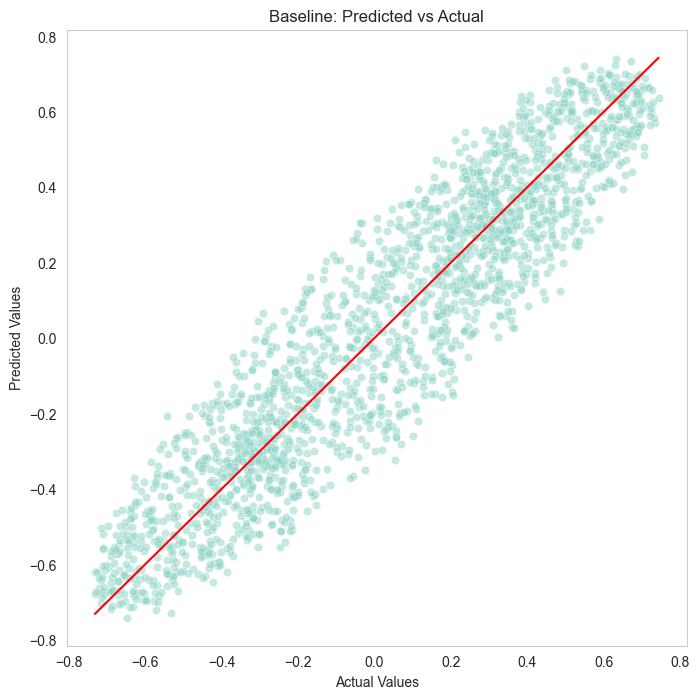

In [8]:
plot_predicted_vs_actual(y_valid, y_pred, title="Baseline: Predicted vs Actual")

### Simple Dense Model

In [15]:
model = keras.models.Sequential([
    layers.Input(shape=(n_steps, 1)),
    layers.Flatten(),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
dense_mse = model.evaluate(X_test, y_test)
print("Dense Model MSE:", dense_mse)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2121 - val_loss: 0.0775
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - val_loss: 0.0326
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0238 - val_loss: 0.0177
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0119
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0094
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - val_loss: 0.0072
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0059
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 
Dense Model MSE: 0.0056711710058152676


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


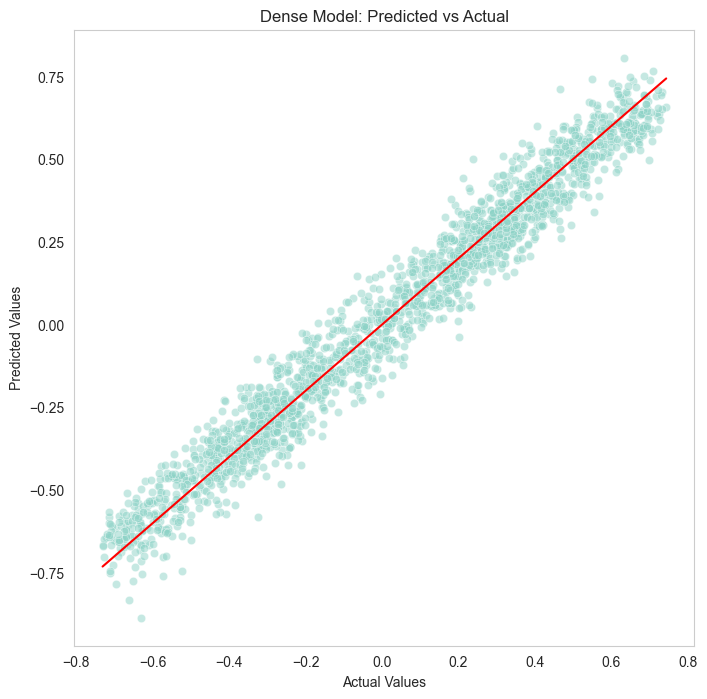

In [10]:
y_pred = model.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred, title="Dense Model: Predicted vs Actual")

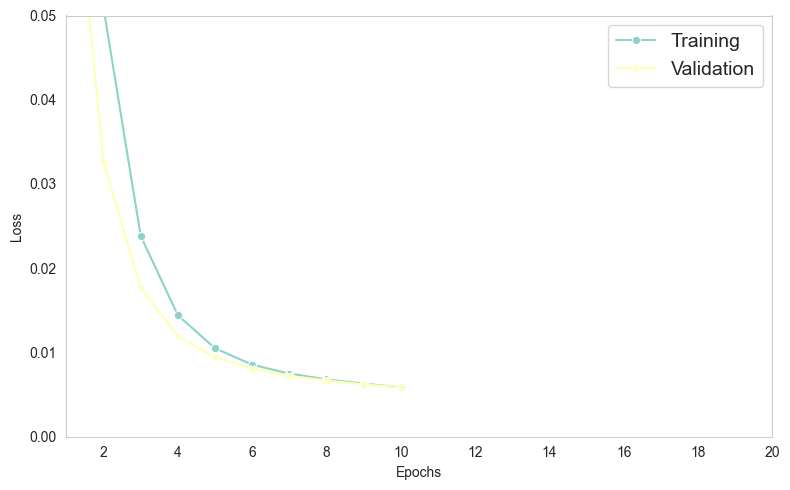

In [23]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

### Simple RNN Model

In [24]:
model = keras.models.Sequential([
    layers.Input(shape=(n_steps, 1)),
    layers.SimpleRNN(20, return_sequences=True),
    layers.SimpleRNN(20),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
rnn_mse = model.evaluate(X_test, y_test)
print("RNN Model MSE:", rnn_mse)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0093 - val_loss: 0.0036
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0027 - val_loss: 0.0029
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
RNN Model MSE: 0.0028786358889192343


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


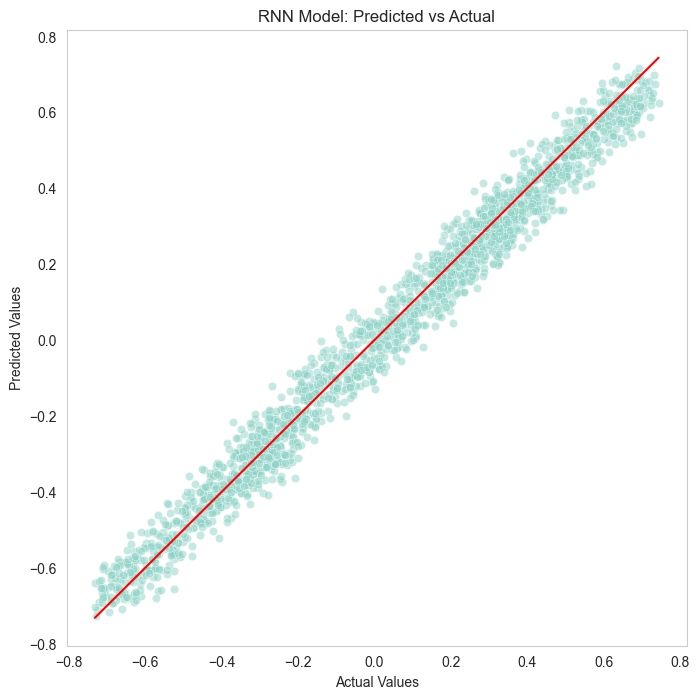

In [25]:
y_pred = model.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred, title="RNN Model: Predicted vs Actual")

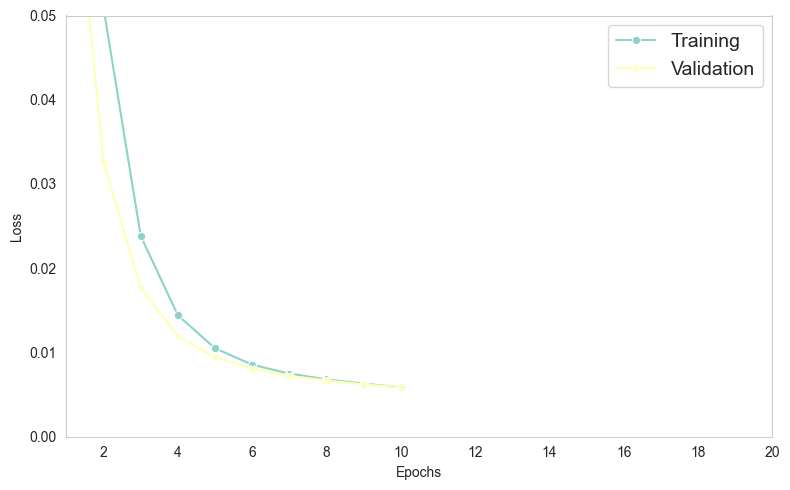

In [26]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

### Deep RNN Model

In [27]:
model = keras.models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.SimpleRNN(20, return_sequences=True),
    layers.SimpleRNN(20),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
deep_rnn_mse = model.evaluate(X_test, y_test)
print("Deep RNN Model MSE:", deep_rnn_mse)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0365 - val_loss: 0.0069
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0029 - val_loss: 0.0030
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Deep RNN Model MSE: 0.0028452943079173565


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


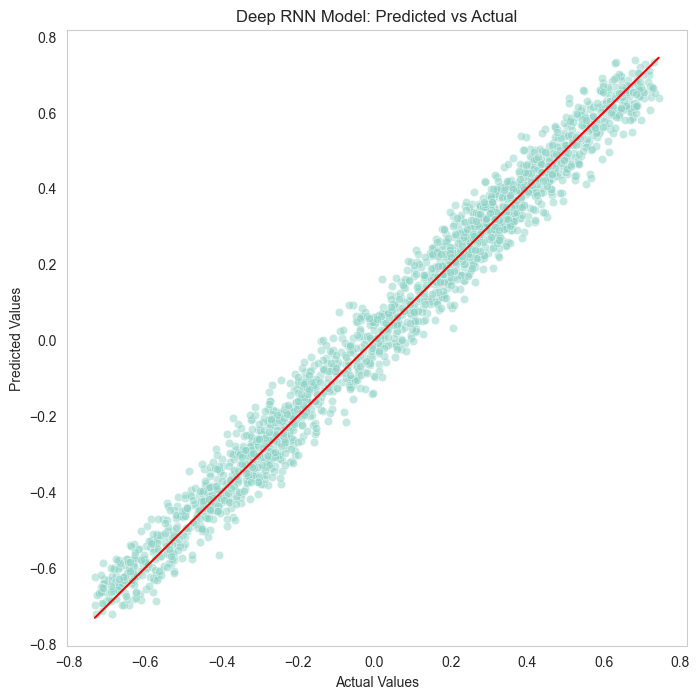

In [28]:
y_pred = model.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred, title="Deep RNN Model: Predicted vs Actual")

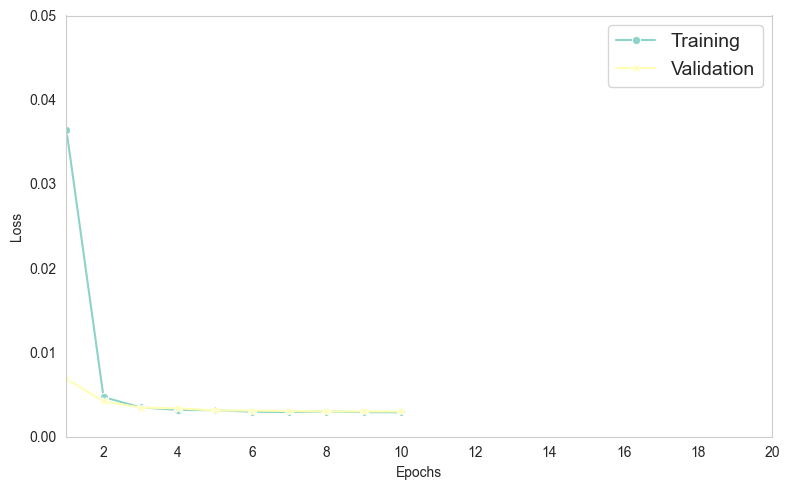

In [29]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

### Data Forecasting with RNNs

In [30]:
series = generate_time_series(1, n_steps + 10)
X_new, y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred = model.predict(X[:, -n_steps:])
    X = np.concatenate([X, y_pred[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


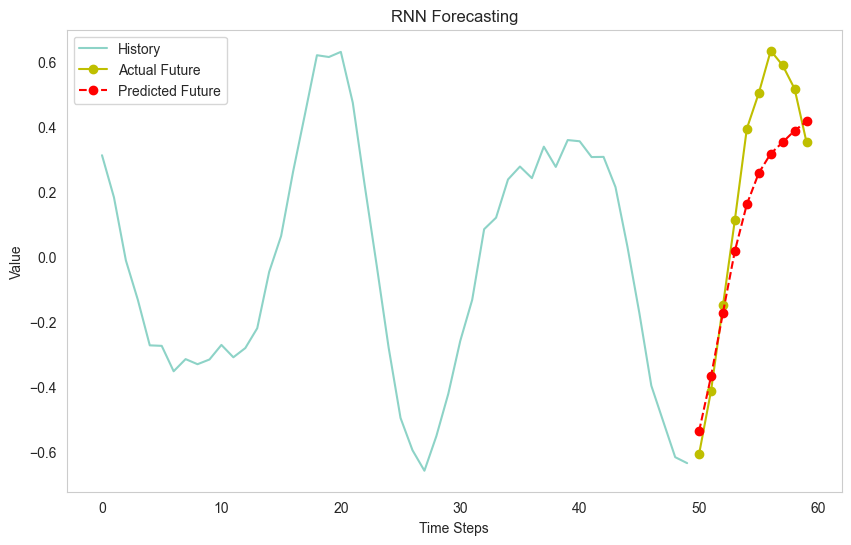

In [31]:
# Plot the results
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(range(n_steps), X_new[0, :n_steps], label="History")
plt.plot(range(n_steps, n_steps + 10), y_new[0], "yo-", label="Actual Future")
plt.plot(range(n_steps, n_steps + 10), y_pred[0], "ro--", label="Predicted Future")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("RNN Forecasting")
plt.legend()
plt.grid()
plt.show()

In [32]:
# --- Multi-step sequence-to-sequence training setup ---

n_steps = 50
horizon = 10
n_series = 10000

# Regenerate series for training (do not reuse the (1, ...) series from forecasting)
series = generate_time_series(n_series, n_steps + horizon)  # (10000, 60, 1)

# Inputs: first n_steps time steps
X = series[:, :n_steps, :]   # shape: (10000, 50, 1)

# Targets: for each time step t, next 10 values x_{t+1}..x_{t+10}
Y = np.empty((n_series, n_steps, horizon), dtype=np.float32)
for t in range(n_steps):
    Y[:, t, :] = series[:, t + 1 : t + 1 + horizon, 0]  # (10000, 10)

X_train, X_valid, X_test = X[:7000], X[7000:9000], X[9000:]
Y_train, Y_valid, Y_test = Y[:7000], Y[7000:9000], Y[9000:]

In [33]:
model = keras.models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.SimpleRNN(20, return_sequences=True),
    layers.SimpleRNN(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10)) # output 10 values at each time step
])

In [34]:
def last_time_step_mse(y_true, y_pred):
    """
     Custom loss function to compute MSE only for the last time step
    """
    return losses.mse(y_true[:, -1], y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    loss=losses.MSE,
    optimizer=optimizer,
    metrics=[last_time_step_mse]
)

In [35]:
history = model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_valid, Y_valid),
    verbose=1,
)

test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - last_time_step_mse: 0.0423 - loss: 0.0541 - val_last_time_step_mse: 0.0234 - val_loss: 0.0379
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0226 - loss: 0.0361 - val_last_time_step_mse: 0.0205 - val_loss: 0.0333
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - last_time_step_mse: 0.0192 - loss: 0.0321 - val_last_time_step_mse: 0.0194 - val_loss: 0.0311
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0171 - loss: 0.0298 - val_last_time_step_mse: 0.0164 - val_loss: 0.0287
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - last_time_step_mse: 0.0146 - loss: 0.0276 - val_last_time_step_mse: 0.0119 - val_loss: 0.0252
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - last_time_step_mse: 0.0112 - loss: 0.0249 - val_last_time_step_mse: 0.0110 - val_loss: 0.0246
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - last_time_step_mse: 0.0101 - loss: 0.0229 - val_la

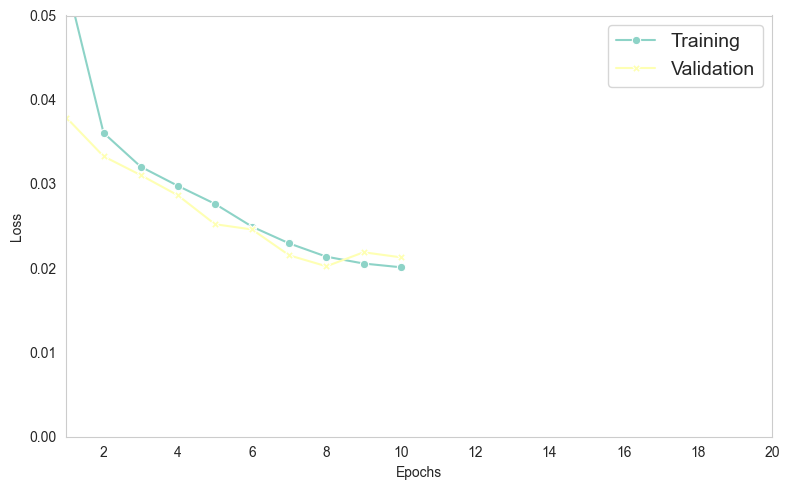

In [37]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

#  Long Sequence processing via RNNs

In [38]:
# - BatchNormalization cannot be used with variable-length sequences ( RNN )
# - Better use Layer Normalization

class LayerNormalizationRNNCell(layers.Layer):
    """
    Custom RNN Cell with Layer Normalization
    Based on SimpleRNNCell with Layer Normalization applied to outputs
    """
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states, training=None):
        outputs, new_states = self.simple_rnn_cell(inputs, states, training=training)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [39]:
model = models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.RNN(LayerNormalizationRNNCell(20), return_sequences=True),
    layers.RNN(LayerNormalizationRNNCell(20), return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    loss=losses.MSE,
    optimizer=optimizer,
    metrics=[last_time_step_mse]
)

history = model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_valid, Y_valid),
    verbose=1,
)

test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

Epoch 1/10


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'layer_normalization_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'layer_normalization_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - last_time_step_mse: 0.0609 - loss: 0.0708 - val_last_time_step_mse: 0.0313 - val_loss: 0.0413
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0259 - loss: 0.0374 - val_last_time_step_mse: 0.0249 - val_loss: 0.0339
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - last_time_step_mse: 0.0185 - loss: 0.0310 - val_last_time_step_mse: 0.0169 - val_loss: 0.0285
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - last_time_step_mse: 0.0153 - loss: 0.0279 - val_last_time_step_mse: 0.0147 - val_loss: 0.0271
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0141 - loss: 0.0263 - val_last_time_step_mse: 0.0174 - val_loss: 0.0277
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - last_time_step_mse: 0.0128 - loss: 0.0249 - val_last_time_step_mse: 0.0099 - val_loss: 0.0226
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - last_time_step_mse: 0.0103 - loss: 0.0229 - val_last_time_ste

In [42]:
X_train.shape

(7000, 50, 1)

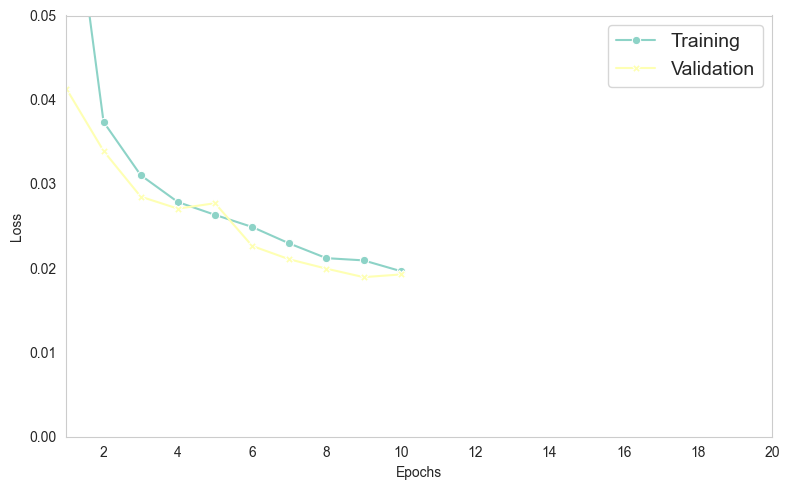

In [40]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

# Shot Memory Prevention Techniques for RNNs

In [43]:
# use LSTM cell (Long Short-Term Memory)
model = models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.LSTM(20, return_sequences=True),
    layers.LSTM(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    loss=losses.MSE,
    optimizer=optimizer,
    metrics=[last_time_step_mse]
)

history = model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_valid, Y_valid),
    verbose=1,
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - last_time_step_mse: 0.0324 - loss: 0.0465 - val_last_time_step_mse: 0.0157 - val_loss: 0.0313
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0121 - loss: 0.0276 - val_last_time_step_mse: 0.0096 - val_loss: 0.0249
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0081 - loss: 0.0229 - val_last_time_step_mse: 0.0061 - val_loss: 0.0204
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - last_time_step_mse: 0.0050 - loss: 0.0190 - val_last_time_step_mse: 0.0050 - val_loss: 0.0180
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - last_time_step_mse: 0.0042 - loss: 0.0172 - val_last_time_step_mse: 0.0037 - val_loss: 0.0165
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - last_time_step_mse: 0.0038 - loss: 0.0163 - val_last_time_step_mse: 0.0038 - val_loss: 0.0160
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - last_time_step_mse: 0.0035 - loss: 0.0156 - val_la

In [46]:
test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - last_time_step_mse: 0.0027 - loss: 0.0142
Test loss: 0.014191856607794762
Test last-step MSE: 0.002690511289983988


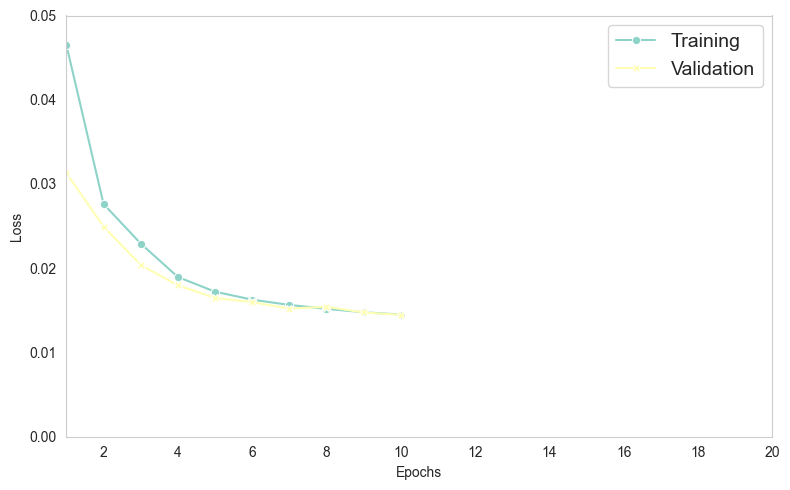

In [44]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

### GRUs ( Gated Recurrent Units ) - lightweight alternative to LSTMs

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    layers.Input(shape=(None, 1)),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - last_time_step_mse: 0.0690 - loss: 0.0770 - val_last_time_step_mse: 0.0424 - val_loss: 0.0528
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - last_time_step_mse: 0.0367 - loss: 0.0481 - val_last_time_step_mse: 0.0344 - val_loss: 0.0451
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - last_time_step_mse: 0.0309 - loss: 0.0428 - val_last_time_step_mse: 0.0283 - val_loss: 0.0403
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - last_time_step_mse: 0.0257 - loss: 0.0383 - val_last_time_step_mse: 0.0237 - val_loss: 0.0366
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - last_time_step_mse: 0.0213 - loss: 0.0347 - val_last_time_step_mse: 0.0200 - val_loss: 0.0337
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - last_time_step_mse: 0.0172 - loss: 0.0317 - val_last_time_step_mse: 0.0155 - val_loss: 0.0304
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - last_time_step_mse: 0.0147 - loss: 0.0297 - 

In [51]:
test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - last_time_step_mse: 0.0116 - loss: 0.0266
Test loss: 0.02657986618578434
Test last-step MSE: 0.011587348766624928


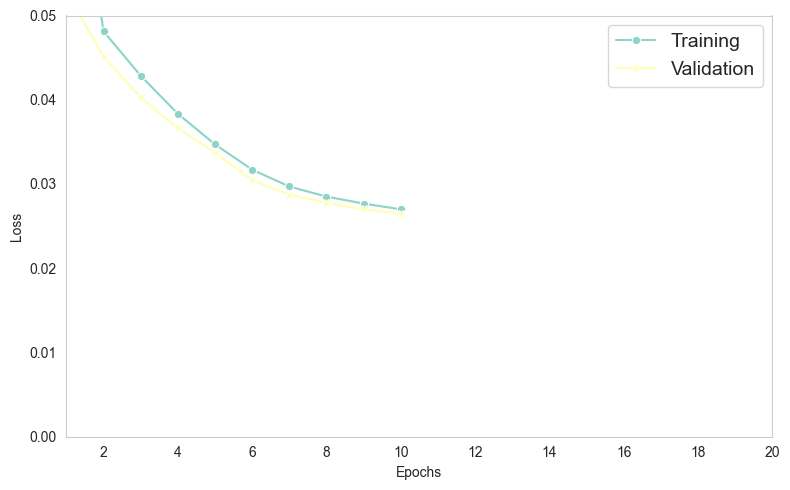

In [52]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Use 1D Convolutions + RNNs for long sequences

model = keras.models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="causal", activation="relu"),
    layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="causal", activation="relu"),
    layers.GRU(20, return_sequences=True),
    layers.GRU(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

In [53]:
model = keras.models.Sequential([
    layers.Input(shape=(None, 1)),
    layers.Conv1D(filters=20,
                  kernel_size=4,
                  strides=2,
                  padding="valid",
                  activation="relu"),
    layers.GRU(20, return_sequences=True),
    layers.GRU(20, return_sequences=True),
    layers.TimeDistributed(layers.Dense(10))
])

model.compile(loss="mse",
              optimizer="adam",
              metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_valid, Y_valid),
                    verbose=1)

Epoch 1/10


ValueError: Dimensions must be equal, but are 50 and 24 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, sequential_11_1/time_distributed_5_1/transpose_1)' with input shapes: [?,50,10], [?,24,10].

In [ ]:
test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### WaveNet Architecture

In [54]:
model = models.Sequential()

model.add(layers.Input(shape=(None, 1)))

for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(layers.Conv1D(
        filters=20,
        kernel_size=2,
        padding="causal",
        activation="relu",
        dilation_rate=dilation_rate
    ))

model.add(layers.Conv1D(filters=10, kernel_size=1))

model.compile(
    loss="mse",
    optimizer="adam",
    metrics=[last_time_step_mse]
)

history = model.fit(
    X_train, Y_train,
    epochs=10,
    validation_data=(X_valid, Y_valid),
    verbose=1
)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - last_time_step_mse: 0.0570 - loss: 0.0666 - val_last_time_step_mse: 0.0241 - val_loss: 0.0363
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0207 - loss: 0.0336 - val_last_time_step_mse: 0.0193 - val_loss: 0.0315
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0176 - loss: 0.0301 - val_last_time_step_mse: 0.0169 - val_loss: 0.0291
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0156 - loss: 0.0281 - val_last_time_step_mse: 0.0153 - val_loss: 0.0275
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0143 - loss: 0.0269 - val_last_time_step_mse: 0.0141 - val_loss: 0.0264
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - last_time_step_mse: 0.0135 - loss: 0.0260 - val_last_time_step_mse: 0.0134 - val_loss: 0.0257
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - last_time_step_mse: 0.0130 - loss: 0.0254 - val_las

In [55]:
test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - last_time_step_mse: 0.0115 - loss: 0.0239
Test loss: 0.023899149149656296
Test last-step MSE: 0.011543093249201775


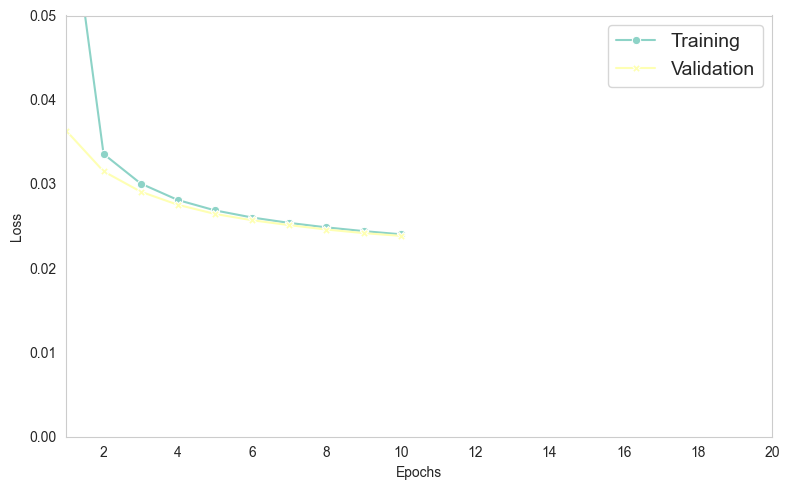

In [56]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [57]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [58]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = layers.Conv1D(n_filters, kernel_size=1)(z)
    return layers.Add()([z, inputs]), z

In [59]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_valid, Y_valid),
                    verbose=1)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - last_time_step_mse: 0.1325 - loss: 0.1371

In [ ]:
test_loss, test_last_step_mse = model.evaluate(X_test, Y_test)
print("Test loss:", test_loss)
print("Test last-step MSE:", test_last_step_mse)

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()